In [2]:
## math, plotting
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd
import scipy.stats
from statannot import add_stat_annotation
import statsmodels.api as sm
from statsmodels.formula.api import ols


## machine learning
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


import pickle

import sys
from os import listdir
sys.path.append('../../Beltway_Project/')
sys.path.append('../../RatterdamOpen_Project/')
sys.path.append('../DATA/')
sys.path.append('../../../ratterdam/')


import RateMapClass_William_20190308 as RateMapClass
import ratterdam_RepetitionCoreFx as CoreFx
import confounds as direction
import newAlleyBounds as bounds2

In [3]:
## Changes in representation with time
## Population vector correlation heatmaps
## x and y axis - time windows

rep_nonrep = 'rep' ## 'nonrep' ## 'both'
def correlation_finder(rep_nonrep):
    ## Reading in file with all data
    file = open('../DATA/20220405-124315_superPopulationRepetition.pickle','rb')
    alldat = pickle.load(file)
    store_dir = '../DATA/FILES/'

    interneuron_thresh = 0.03 ##0.08
    interneuron_num_alleys = 17
    all_delta_corr = [[],[],[],[],[],[],[]]
    ##fig, axs = plt.subplots(5,2, figsize = (12,30))
    num_cells = []
    all_rats = list(alldat.keys())
    figy = 0
    for rat in all_rats:
        all_days = list(alldat[rat].keys())
        figx = 0
        for day in all_days:
            day_neur = rat + '_' + day
            print(day_neur)
            anorm = np.load(store_dir + rat + '_' + day + '_time_alley_neur_normalized_.npy')
            anorm[anorm == np.inf] = np.NaN

            repeating_cells = []
            all_cells = alldat[rat][day]['units'].keys()
            for each_cell in all_cells:
                data = alldat[rat][day]['units'][each_cell]
                if data.repeating == True:
                    repeating_cells.append(True)
                else:
                    repeating_cells.append(False)

            if rep_nonrep == 'rep':
                anorm = anorm[:,:, repeating_cells]
            elif rep_nonrep == 'nonrep':
                anorm = anorm[:,:, ~np.array(repeating_cells)]


            ## excluding interneurons
            exclude_only = np.nanmean(anorm, axis = (0,1))> interneuron_thresh
            exclude_only= exclude_only*(np.sum(np.nanmean(anorm, axis = 0)>interneuron_thresh, axis = 0)>interneuron_num_alleys)
            include_only = ~exclude_only
            anorm = anorm[:,:, include_only]

            if np.shape(anorm)[2]!=0:
                corr_plot = np.zeros((len(anorm), len(anorm)))
                for i in range(0, len(anorm)):
                    for j in range(0, len(anorm)):
                        if True not in np.isnan(anorm[i]) and True not in np.isnan(anorm[j]) and i!=j:
                            corr_plot[i,j] = scipy.stats.pearsonr(anorm[i].flatten(),anorm[j].flatten())[0]
                            if i>=j:
                                all_delta_corr[abs(i-j)].append(corr_plot[i,j])
                        else:
                            no_na_i = ~np.isnan(anorm[i].flatten())
                            no_na_j = ~np.isnan(anorm[j].flatten())
                            no_na = no_na_i*no_na_j
                            corr_plot[i,j] = scipy.stats.pearsonr(anorm[i].flatten()[no_na],anorm[j].flatten()[no_na])[0]
                            if i>=j:
                                all_delta_corr[abs(i-j)].append(corr_plot[i,j])
                '''sb.heatmap(corr_plot, ax = axs[figy, figx])
                axs[figy, figx].set_title(rat + '_' + day)'''
                ##plt.show()
                figx = figx + 1
        figy = figy + 1
    return all_delta_corr

R765_RFD5
R765_DFD4
R781_D3
R781_D4
R808_D6
R808_D7
R859_D1
R859_D2
R886_D1
R886_D2
R-squared: 0.202581
pvalue: 0.000000
slope: -0.067592


/Users/maanasa/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


R765_RFD5
R765_DFD4
R781_D3
R781_D4
R808_D6
R808_D7
R859_D1
R859_D2
R886_D1
R886_D2
R-squared: 0.164064
pvalue: 0.000000
slope: -0.053573


/Users/maanasa/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


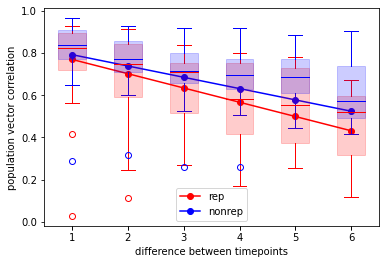

In [4]:
## plots a single figure showing drop in population-vector correlation with increasing time difference

fig, ax = plt.subplots()
all_rep_nonrep = ['rep', 'nonrep']
rep_colors = ['red', 'blue']
df_corr_created = False
for curr_rep_nonrep in range(len(all_rep_nonrep)):
    rep_nonrep = all_rep_nonrep[curr_rep_nonrep]
    all_delta_corr = correlation_finder(rep_nonrep)
    if df_corr_created == False:
        df_corr = pd.DataFrame(np.array([np.ones(len(all_delta_corr[1])),np.array(all_delta_corr[1]).astype('float'), [curr_rep_nonrep]*len(all_delta_corr[1])]).T, columns = ['time', 'correlation', 'repetition'])
        df_corr_created = True
    else:
        df_new = pd.DataFrame(np.array([np.ones(len(all_delta_corr[1])),np.array(all_delta_corr[1]).astype('float'), [curr_rep_nonrep]*len(all_delta_corr[1])]).T, columns = ['time', 'correlation', 'repetition'])
        df_corr = df_corr.append(df_new, ignore_index = True)
    for j in range(2, len(all_delta_corr)):
        df_new = pd.DataFrame(np.array([j*np.ones(len(all_delta_corr[j])),np.array(all_delta_corr[j]).astype('float'), [curr_rep_nonrep]*len(all_delta_corr[j])]).T, columns = ['time', 'correlation', 'repetition'])
        df_corr = df_corr.append(df_new, ignore_index = True)


    ##res = scipy.stats.linregress(df_corr)
    res = scipy.stats.linregress(df_corr['time'].astype('float'), df_corr['correlation'].astype('float'))
    print(f"R-squared: {res.rvalue**2:.6f}")
    print(f"pvalue: {res.pvalue:.6f}")
    print(f"slope: {res.slope:.6f}")

    b1 = ax.boxplot(all_delta_corr[1:],patch_artist=True)

    [patch.set(alpha=0.2) for patch in b1['boxes']]
    plt.setp(b1["fliers"], markeredgecolor=rep_colors[curr_rep_nonrep] )
    plt.setp(b1["boxes"], facecolor=rep_colors[curr_rep_nonrep] )
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(b1[item], color=rep_colors[curr_rep_nonrep])
    
    ax.set_xticklabels(np.arange(1, len(all_delta_corr)))
    ax.set_xlabel('difference between timepoints')
    ax.set_ylabel('population vector correlation')
    ax.plot(np.arange(1, 7, 1), res.intercept + res.slope*np.arange(1, 7, 1), '-o', label=rep_nonrep, color = rep_colors[curr_rep_nonrep] )
    ax.set_label(rep_nonrep)
plt.legend()
plt.show()
    ##plt.show()

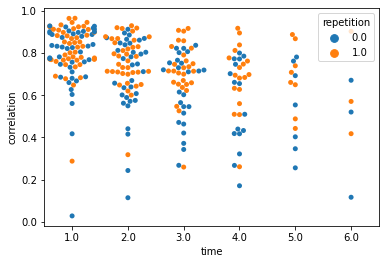

In [5]:
sb.swarmplot(df_corr['time'],df_corr['correlation'], hue = df_corr['repetition'] )

In [6]:
## statistics
num_tests = len(np.unique(np.array(df_corr['time'])))
alpha = 0.05/num_tests
all_time_curr = np.arange(1.0, 7.0, 1)
pval_all = []
for time_curr in all_time_curr:
    rep_df = df_corr.loc[(df_corr['time'] == time_curr) & (df_corr['repetition'] == 0)]
    nonrep_df = df_corr.loc[(df_corr['time'] == time_curr) & (df_corr['repetition'] == 1)]
    pval_all.append(scipy.stats.ttest_ind(np.array(rep_df['correlation']), np.array(nonrep_df['correlation'])).pvalue)
    
    if pval_all[-1]<alpha:
        significance  = True
    else:
        significance  = False
        
    print(time_curr, pval_all[-1], significance)

1.0 0.1440436165601319 False
2.0 0.056088220670682254 False
3.0 0.03810804441974694 False
4.0 0.044460819511745166 False
5.0 0.17194935735074737 False
6.0 0.4244956816280011 False


In [7]:
model = ols('correlation ~ C(time) + C(repetition) + C(time):C(repetition)', data=df_corr).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(time),1.404025,5.0,11.382295,6.103610e-10
C(repetition),0.423466,1.0,17.165004,4.643739e-05
C(time):C(repetition),0.087348,5.0,0.708126,6.178052e-01
Residual,6.389615,259.0,NaN,NaN
